### Tweeter setiment analysis with VADER

#### Prerequisites:

Register for the Twitter API:
 - Go to https://apps.twitter.com  
 - click on "Create New Application"   
 - Under Application details, enter name, description, website details (can be anything)  
 - click on "Create Application" and e) make a note of the tokens on the "Keys and Access Tokens" tab  

#### Utilize a Sentiment Dictionary to decipher the sentiment of text

A sentiment dictionary is the mapping of words to sentiment values. For example: the word awesome (which is a positive sentiment) could have a value of +3.7 and the word horrible (which is a negative sentiment) could have a value of -3.1. While using a sentiment dictionary, the values of the sentiment words are summed to get the overall sentiment of the text. 

For example: I loved the ambience of the restaurant but the drive to the restaurant was horrendous. Overall, it was a good evening.

Now let's say the value of the word love is +3.9, the value of the word horrendous is -4.2 and the value of the word good is +2.9. So, the overall sentiment of the text is positive since the aggregate of the values of the sentiment words is positive. 

We will apply `VADER` Sentiment analysis to tweets. VADER stands for Valence Aware Dictionary for Sentiment Reasoning. The dictionary was designed specifically for Twitter and contains emoticons and slang. **It also provides support for sentiment intensifiers  (words such as incredibly funny) and negations (words such as "not bad" which is a slight/small positive sentiment)**. 

How it works? VADER analyzes a piece of text to check if any of the words in the text are present in the lexicon. It  produces 4 sentiment metrics from the word ratings i.e. positive, neutral, negative and compound. The compound score is the sum of all of the lexicon ratings which is standardized to a range between -1 and 1.

In [1]:
# !pip install tweepy==4.1.0
# !pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import os
import json
import glob
import datetime
import time
import pytz
import tweepy

In [3]:
tweepy.__version__

'4.1.0'

In [4]:
#Load the SentimentIntensityAnalyzer object from the VADER package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create a handle to the SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

#function that outputs the sentiment ratings
def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))
    
#Examining the sentiment ratings for different pieces of text
#No sentiment expressed

print_sentiment_ratings("I have to work on the weekend")

#Overall rating is neutral

I have to work on the weekend {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [5]:
#Sentiment expressed via emoticon

print_sentiment_ratings("I have to work on the weekend :(")

#Overall rating is negative

I have to work on the weekend :( {'neg': 0.293, 'neu': 0.707, 'pos': 0.0, 'compound': -0.4404}


In [6]:
#Expressing a more intense feeling via 2 emoticons

print_sentiment_ratings("I have to work on the weekend :( :(")

#Overall rating is even more negative than the above piece of text

I have to work on the weekend :( :( {'neg': 0.453, 'neu': 0.547, 'pos': 0.0, 'compound': -0.7003}


In [7]:
#VADER handles emotion intensifiers (i.e. words such as very, really, super, etc.)

print_sentiment_ratings("I did well on the test")

#The sentiment rating for the sentence below is higher than the one above

print_sentiment_ratings("I did very well on the test")

I did well on the test {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.2732}
I did very well on the test {'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.3384}


In [8]:
#VADER takes into consideration how the words are written - capitalization has an impact on the sentiment ratings

print_sentiment_ratings("I had a super day")

#The sentiment rating for the sentence below is higher than the one above

print_sentiment_ratings("I had a SUPER day")

I had a super day {'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'compound': 0.5994}
I had a SUPER day {'neg': 0.0, 'neu': 0.463, 'pos': 0.537, 'compound': 0.6841}


In [9]:
#Finally, VADER handles changes in sentiment intensity; specifically when a sentence contains the word "but". Higher weighting is given to the sentiment after the word "but".
#The overall rating for the sentence below is negative

print_sentiment_ratings(" I loved the ambience of the restaurant but the drive to the restaurant was horrendous")

 I loved the ambience of the restaurant but the drive to the restaurant was horrendous {'neg': 0.252, 'neu': 0.63, 'pos': 0.119, 'compound': -0.5789}


**Build a Twitter Sentiment Analyzer**

A common question that often arises is how do I decipher the sentiment within a large set of tweets regarding a specific topic on Twitter in an autonomous fashion. Now, we will construct a Twitter Sentiment Analyzer. The Sentiment Analyzer will search twitter for a list of tweets about any topic of choice, then it will analyze each tweet to ascertain whether a positive or negative emotion is expressed in the tweet. 

**Authenticate with Twitter**

In [10]:
#Define 4 variables for authenticating with Twitter
#Each student will have their own unique tokens
consumer_key = '** provide your key **'
consumer_secret= '** provide your secret **'

access_token = '** provide your access token **'
access_token_secret = '** provide your access token secret **'

#Autenticate with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

**Search twitter for a list of tweets about any topic of choice, then it will analyze each tweet to ascertain whether a positive or negative emotion is expressed in the tweet. **

In [11]:
#Get a connection to Twitter
# tweetapi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=False)
tweetapi = tweepy.API(auth)

#This method is going to return tweets that contain the word 
visible_public_tweets = tweetapi.search_tweets('facebook')

print(f"Retrieved {len(visible_public_tweets)} tweets")

Retrieved 15 tweets


In [12]:
# Iterate through the tweets that have been retrieved
# Append VADER sentiment scores

tweet_id = []
tweet_lang = []
tweet_created_at = []
tweet_retweet_count = []
tweet_text = []

tweet_sentiment_score = []
sentiment_df = pd.DataFrame(columns=\
  ['id', 'lang', 'created_at', 'retweet_count',
   'text' ,'sentiment_score'])


for tweet in visible_public_tweets:
    analyzer = SentimentIntensityAnalyzer()

    tweet_id.append(str(tweet.id))
    tweet_lang.append(str(tweet.lang))
    tweet_created_at.append(str(tweet.created_at))
    tweet_retweet_count.append(str(tweet.retweet_count))    
    tweet_text.append(str(tweet.text))

    tweet_sentiment_score.append(str(analyzer.polarity_scores(tweet.text)["compound"]))


sentiment_df['id'] = tweet_id
sentiment_df['lang'] = tweet_lang
sentiment_df['created_at'] = tweet_created_at
sentiment_df['retweet_count'] = tweet_retweet_count
sentiment_df['text'] = tweet_text

sentiment_df['sentiment_score'] = tweet_sentiment_score

sentiment_df['text'] = sentiment_df['text'].str.replace('\n', ' ')


# Create a positive / negative sentiment variable
sentiment_df['sentiment'] = np.where(sentiment_df['sentiment_score'].astype(np.float) > 0, 'Positive', 'Negative')
sentiment_df['sentiment'] = np.where(sentiment_df['sentiment_score'].astype(np.float) == 0, 'Neutral', sentiment_df['sentiment'])

In [13]:
sentiment_df

,id,lang,created_at,retweet_count,text,sentiment_score,sentiment
0,1447372776353026052,es,2021-10-11 01:25:35+00:00,34,"RT @CiroGomezL: “#Facebook daña a la niñez, av...",0.0,Neutral
1,1447372776269090818,en,2021-10-11 01:25:35+00:00,28,RT @jamisonfoser: @DouthatNYT You wrote Silico...,-0.3535,Negative
2,1447372773207121920,und,2021-10-11 01:25:34+00:00,532,RT @MusicLibraryTH: 2021 #MusicLibraryTOP40 We...,0.0,Neutral
3,1447372772724908036,en,2021-10-11 01:25:34+00:00,2,RT @OakleyBoiii: @GameBattles Would love a spo...,0.8908,Positive
4,1447372769839046659,en,2021-10-11 01:25:33+00:00,7,RT @chickwerner: @donwinslow #Facebook Board o...,-0.5106,Negative
5,1447372763816022016,und,2021-10-11 01:25:32+00:00,0,https://t.co/BRADU7vuUP,0.0,Neutral
6,1447372760754262017,en,2021-10-11 01:25:31+00:00,0,✨🏆 Best Actress – Television (Comedy) Winner: ...,0.9584,Positive
7,1447372760380887045,tl,2021-10-11 01:25:31+00:00,0,tangina katatapos lang bardagulan dito sa twit...,0.4404,Positive
8,1447372760003403790,tl,2021-10-11 01:25:31+00:00,18,"RT @ustshscomelec: Sulong, botante! Narito na ...",0.0,Neutral
9,1447372759231700997,en,2021-10-11 01:25:31+00:00,239,RT @armyspoke_news: https://t.co/ufixfJwKxV 💂...,0.8481,Positive


**Graph sentiment polarity extracted from tweets**

In the code above, we explored how to connect to Twitter, fetched tweets from twitter on a specific topic and then examined the sentiment of the tweets.  VADER compound score is a float within the range [-1.0, 1.0] where a score greater than 0.0 indicates positive sentiment whereas a score less than 0.0 indicates negative sentiment.

Now, we will create a listener class that continuously listens for tweets on a specific topic, detects the sentiment of the fetched tweets and persists them to a file.

In [14]:
path_tweets = '/home/jupyter/data/tweet_capture'

if not os.path.isdir(path_tweets): os.mkdir(path_tweets)

In [15]:
# Remove existing data

file_list = glob.glob(os.path.join(path_tweets, '*.json'))

for f in file_list:
    os.remove(f)

In [16]:
# Overall tweet volume to collect
MAX_TWEETS = 100

# Max time to listen in minutes
MAX_TIME = 10

# Number of tweets to include in a batch for saving
NUM_BATCH = 10

# Using current time
initial_time = datetime.datetime.now()

#override tweepy.StreamListener to add logic to on_status
class NickCustomStreamListener(tweepy.Stream):
    collected_data = []
    collected_count = 0

    def on_data(self, data):
        all_data = json.loads(data)
        if 'text' in all_data:
          # append collector with tweet enriched by sentiment score
          self.collected_data.append({
              "tweet": all_data["text"],
              "created_at": all_data["created_at"],
              "retweeted": all_data["retweeted"],
              "username": all_data["user"]["screen_name"],
              "user_tz": all_data["user"]["time_zone"],
              "user_location": all_data["user"]["location"],
              "sentiment_score": str(analyzer.polarity_scores(all_data["text"])["compound"])
          })
          # increase count of tweets collected
          self.collected_count += 1
          # batch size achieved
          if self.collected_count % NUM_BATCH == 0:
            now = datetime.datetime.now()
            now_timestamp = datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y-%m-%d_%H:%M:%S")
            with open(f"{path_tweets}/tweets-crawled-{now_timestamp}.json", "w") as f:
                f.write(json.dumps(self.collected_data))
                
            # empty batch collector to free-up memory
            self.collected_data = []
            
        # stop process when max tweets reached
        if (
            (datetime.datetime.now() > initial_time + datetime.timedelta(minutes = MAX_TIME)) or 
            (self.collected_count > MAX_TWEETS)
        ):                
            # stop iterations
            self.disconnect()

In [17]:
initial_time = datetime.datetime.now()

myStream = NickCustomStreamListener(consumer_key, consumer_secret, access_token, access_token_secret)
myStream.filter(track=["COVID", "covid"], languages = ["en"], stall_warnings = True)

In [18]:
# Review collected JSON objects

file_list = glob.glob(os.path.join(path_tweets, '*.json'))
file_list

['/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:45.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:49.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:37.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:47.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:48.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:39.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:44.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:46.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:41.json',
 '/home/jupyter/data/tweet_capture/tweets-crawled-2021-10-10_20:25:43.json']

In [19]:
# Read collected tweets into Pandas dataframe

tweets_df = pd.DataFrame()

for file in file_list:
    temp = pd.read_json(file, orient='records')    
    tweets_df = tweets_df.append(temp, ignore_index = True)


print(f"Number of tweets collected: {tweets_df.shape[0]}")
print(f"Min sentiment: {tweets_df['sentiment_score'].min()}")
print(f"Average sentiment: {tweets_df['sentiment_score'].mean()}")
print(f"Max sentiment: {tweets_df['sentiment_score'].max()}")

Number of tweets collected: 100
Min sentiment: -0.886
Average sentiment: 0.01663999999999999
Max sentiment: 0.8176


In [20]:
pd.set_option('display.max_colwidth', None)

tweets_df[['created_at', 'tweet', 'sentiment_score']]

,created_at,tweet,sentiment_score
0,2021-10-11 01:25:39+00:00,RT @JacquiDelaney: The unmitigated gall.\n\nTofino.\nMcKenna farewell tour.\n5 weeks criss crossing Canada during a needless election.,0.0000
1,2021-10-11 01:25:39+00:00,"As Covid trends down, Fauci warns not to ‘declare victory’ https://t.co/MgNGDQcRO3",-0.1027
2,2021-10-11 01:25:39+00:00,"RT @BazziNYU: Moderna’s attitude amounted to: “We’re here to make money. We’ve stumbled upon a good thing, and we’re not even trying to pre…",0.4404
3,2021-10-11 01:25:39+00:00,@sallymcmanus_ @LaTrioli @PatsKarvelas @Raf_Epstein Siena has closed too due to a covid positive student.,0.5574
4,2021-10-11 01:25:39+00:00,You are not alone! https://t.co/3K1bnr3gtF,0.2575
...,...,...,...
95,2021-10-11 01:25:37+00:00,RT @kylegriffin1: Hawaii just became the first state to administer COVID vaccines to 90% of its residents 12 and older.,0.0000
96,2021-10-11 01:25:37+00:00,"RT @KFF: Had the #COVID19 death rate in the 10 least vaccinated states been the same as the death rate in the 10 most vaccinated states, th…",-0.8316
97,2021-10-11 01:25:37+00:00,RT @DrSasa22222: ANNOUNCEMENT REGARDING THE COVID-19 SITUATION IN MYANMAR BY H.E. DR. SASA\n17 July 2021 https://t.co/Ka1ImsiL7m,0.0000
98,2021-10-11 01:25:37+00:00,"RT @KamalaHarris: Thanks to President @JoeBiden’s leadership, the Department of Labor will require any business with 100 or more employees…",0.4404


#### Plotting sentiment analysis over time

In [21]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

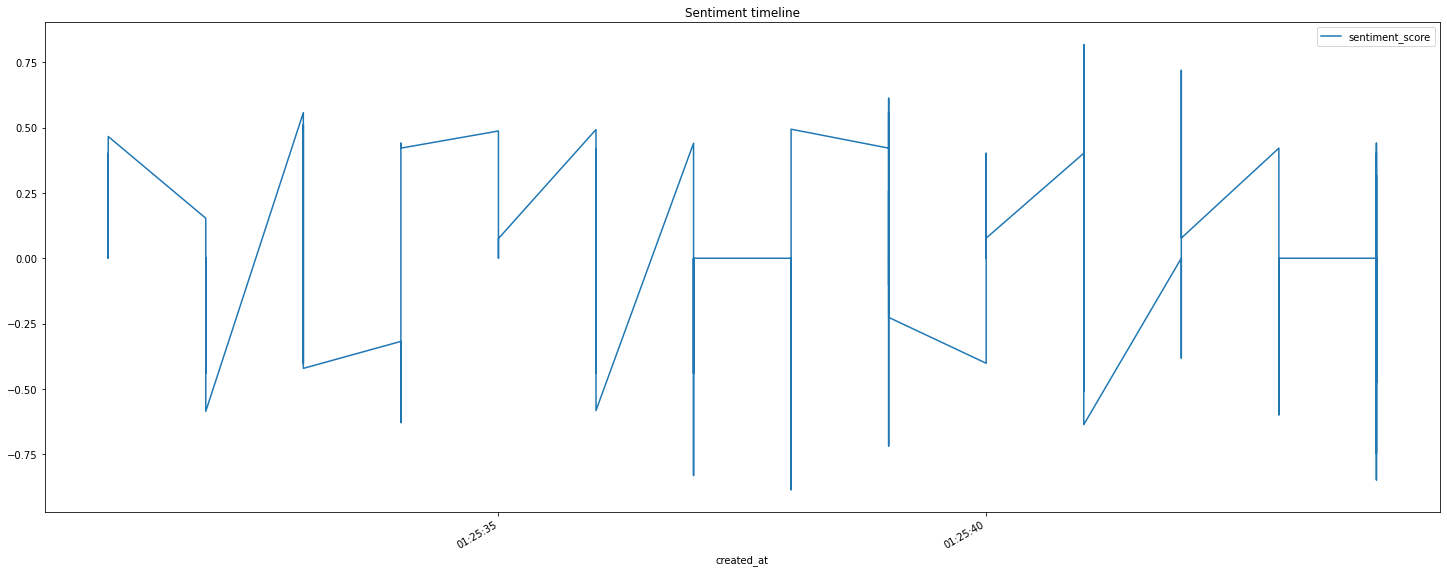

In [22]:
plt.rcParams["figure.figsize"] = (25,10)

tweet_timeline_df = tweets_df.copy()
tweet_timeline_df = tweet_timeline_df[['created_at', 'sentiment_score']].set_index('created_at')


tweet_timeline_df.plot()
plot = plt.title(f'Sentiment timeline')

In [23]:
datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 10 October 2021 20:25:50'